## DS 5110 Final Project - Hospital Mortality
### Team 3
### By: Elena Tsvetskova, Brian Chae, Ryan Viti (rrv7eb)

In [1]:
# importing necessary libraries and packages
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import round, col, isnan, when, count, countDistinct, mean
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation

# session initialization
spark = SparkSession.builder \
        .master("local") \
        .appName("Team 3 Final Project") \
        .getOrCreate()

filename = "hospital_mortality.csv"

data = spark.read.csv(filename, inferSchema=True, header=True)
data.count()

91713

In [2]:
# printing original dataset schema
data.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- hospital_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_id: integer (nullable = true)
 |-- icu_stay_type: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache

## Data Cleaning and EDA

In [3]:
# empty columns, unique identifiers unnecessary for analysis

data = data.drop("_c83", "encounter_id", "patient_id", "hospital_id", "icu_id", "icu_stay_type")

In [4]:
# Distribution of reported diseases
diseases = ["aids", "cirrhosis", "diabetes_mellitus", "hepatic_failure", "leukemia", "lymphoma", "solid_tumor_with_metastasis"]
for i in diseases:
    data.select(i).groupBy(i).count().show()

+----+-----+
|aids|count|
+----+-----+
|null|  715|
|   1|   78|
|   0|90920|
+----+-----+

+---------+-----+
|cirrhosis|count|
+---------+-----+
|     null|  715|
|        1| 1428|
|        0|89570|
+---------+-----+

+-----------------+-----+
|diabetes_mellitus|count|
+-----------------+-----+
|             null|  715|
|                1|20492|
|                0|70506|
+-----------------+-----+

+---------------+-----+
|hepatic_failure|count|
+---------------+-----+
|           null|  715|
|              1| 1182|
|              0|89816|
+---------------+-----+

+--------+-----+
|leukemia|count|
+--------+-----+
|    null|  715|
|       1|  643|
|       0|90355|
+--------+-----+

+--------+-----+
|lymphoma|count|
+--------+-----+
|    null|  715|
|       1|  376|
|       0|90622|
+--------+-----+

+---------------------------+-----+
|solid_tumor_with_metastasis|count|
+---------------------------+-----+
|                       null|  715|
|                          1| 1878|
|        

### Experimenting with NA Origins for Certain Columns

In [5]:
for name in diseases:
    data = data.withColumn(name, col(name).cast('boolean'))

In [6]:
# Quantifying amount of null values in each column of the dataset

data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+----+----------------+---------+------+------+----------------+--------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-------------

In [7]:
# dropping noninvasive measurements due to high frequency of NA and lower accuracy of a noninvasive measurement
condition = lambda col: 'noninvasive' in col
data = data.drop(*filter(condition, data.columns))
# amount of columns remaining after dropping
len(data.columns)

67

In [8]:
import matplotlib.pyplot as plt
num_nulls_df=data.withColumn('numNulls', sum(data[col].isNull().cast('int') for col in data.columns))
# num_nulls_df.filter([data[i].isNull()==False for i in s1list]).show()
# num_nulls_df.filter([col(i).isNull()==False for i in s1list])
disease_nulls_df = num_nulls_df.filter(col('lymphoma').isNull())
disease_nulls_df.select(mean("numNulls")-len(diseases)).alias("AVG_nulls_per_row").show()

+-------------------+
|(avg(numNulls) - 7)|
+-------------------+
| 20.675524475524476|
+-------------------+



In [9]:
# Computing the average number of nulls per row, for reference
num_nulls_column = num_nulls_df.select("numNulls")
filtered = num_nulls_column.filter(col("numNulls")!= 0)
filtered.select(mean(col("numNulls"))).show()

+-----------------+
|    avg(numNulls)|
+-----------------+
|4.505564741795981|
+-----------------+



In [10]:
# Potential correlation matrix creation using pyspark.ml.stat.Correlation here for numeric variables

We will imbalanced response variable in our ML application.
Helpful link for doing so:
https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253

In [11]:
import matplotlib.pyplot as plt
num_nulls_df=data.withColumn('numNulls', sum(data[col].isNull().cast('int') for col in data.columns))
# num_nulls_df.filter([data[i].isNull()==False for i in s1list]).show()
# num_nulls_df.filter([col(i).isNull()==False for i in s1list])
less_nulls_df = num_nulls_df.filter(col('h1_mbp_min').isNotNull())
# less_nulls = less_nulls.filter(less_nulls.numNulls < 3)
# less_nulls.count()
x = range(1,11)
y = []
for i in range(1, 11):
    y.append(less_nulls_df.filter(less_nulls_df.numNulls < i).count())
# less_nulls_df = num_nulls_df.filter((num_nulls_df.numNulls < 2) and col('h1_mbp_min').isNotNull())
# less_nulls_df.count()

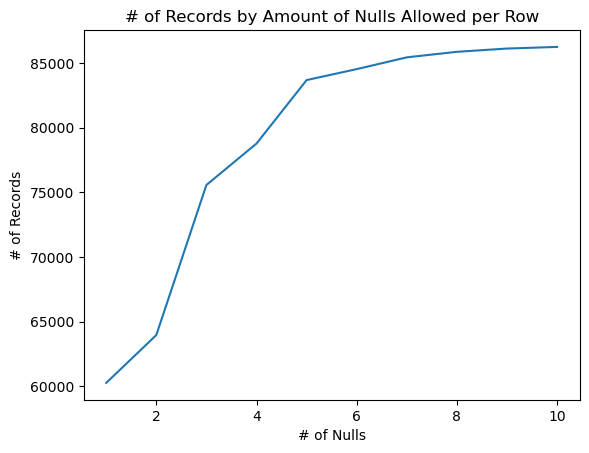

In [12]:
plt.title('# of Records by Amount of Nulls Allowed per Row')
plt.xlabel('# of Nulls')
plt.ylabel('# of Records')
plt.plot(x, y)
plt.show()

Using a threshold of 3 nulls per row, due to apparent elbow in our Records vs. Nulls plot.

In [13]:
less_nulls_df = less_nulls_df.filter(less_nulls_df.numNulls < 5)
df_cleaned = less_nulls_df.drop("apache_4a_hospital_death_prob", "apache_4a_icu_death_prob", "d1_potassium_max", "d1_potassium_min", "numNulls")

In [14]:
df_cleaned_numRows = df_cleaned.count()
df_cleaned_numRows

83672

In [15]:
# Outcome variable distribution
df_cleaned.groupBy("hospital_death").count().show()

+--------------+-----+
|hospital_death|count|
+--------------+-----+
|             1| 7168|
|             0|76504|
+--------------+-----+



### Percentage of Columns containing NA values

In [ ]:
df_NAcheck = df_cleaned.select([round((count(when(col(c).isNull(), c))/df_cleaned_numRows),3).alias(c) for c in df_cleaned.columns])
df_NAcheck.show()

In [33]:
print("Number of Columns containing greater than 5% NA values: {}".format([(df_NAcheck.first()[c] > 0.05) for c in df_NAcheck.columns].count(True)))

Number of Columns greater than 5% of NA values: 0


Single imputation is ill-advised based on multiple research studies when dealing with healthcare data, so we will avoid this and instead, since the ratio of NAs in every column falls below 0.05, we will consider it feasible to drop the remaining rows containing null values.

In [17]:
print("Number of rows saved via cleaning + EDA: {}".format((df_cleaned.dropna().count()-data.dropna().count())))

Number of rows saved via cleaning + EDA: 8329


In [ ]:
# load pyspark modules
from pyspark.ml import Pipeline  
from pyspark.ml.feature import OneHotEncoder, StringIndexer

#create a list of the columns that are string typed
categoricalColumns = [item[0] for item in cleaned_data_2.dtypes if item[1].startswith('string') ]

#define a list of stageJs in your pipeline. The string indexer will be one stage
stages = []

#iterate through all categorical values
for categoricalCol in categoricalColumns:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

#Create the pipeline. Assign the stages list to the pipeline key word stages
pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(cleaned_data_2)
#transform the dataframe
df= pipelineModel.transform(cleaned_data_2)
df.take(2)

In [ ]:
df_2 = df.drop("ethnicity", "gender", "icu_admit_source", "icu_type", "apache_3j_bodysystem", "apache_2_bodysystem")
df_2.printSchema()

In [ ]:
#feature_columns = df_2.select([c for c in df_2.columns if c not in {'hospital_death'}])
#feature_columns.take(1)

va = VectorAssembler(inputCols=[c for c in df_2.columns if c not in {'hospital_death'}], outputCol="features")  
output = va.transform(df_2)
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(output)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(output)
df_scaled.take(5)

In [ ]:
from pyspark.ml.feature import PCA

# PCA using 4 components
pca = PCA(k=6, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(df_scaled)

# extract the transformed features
result = model.transform(df_scaled)

result.take(1)

In [ ]:
import numpy as np

np.round(100.00*model.explainedVariance.toArray(),4)

In [ ]:
import pandas as pd

cols = df_2.drop('hospital_death').columns
cols

pcs = np.round(model.pc.toArray(),4)
df_pc = pd.DataFrame(pcs, columns = ['PC1','PC2','PC3','PC4','PC5','PC6'], index = cols)
df_pc

In [ ]:
pc1 = df_pc.loc[:,'PC1'].abs().sort_values(ascending=False)
s1 = pc1[pc1 > 0.2]
s1

In [ ]:
s1index=s1.index
s1list = list(s1index)
s1list

In [ ]:
pc2 = df_pc.loc[:,'PC2'].abs().sort_values(ascending=False)
s2 = pc2[pc2 > 0.2]
s2

In [ ]:
s2index=s2.index
s2index

In [ ]:
pc3 = df_pc.loc[:,'PC3'].abs().sort_values(ascending=False)
s3 = pc3[pc3 > 0.2]
s3

In [ ]:
s3index=s3.index
s3index

In [ ]:
#Union the series indices

important_vars = s3index.union(s2index).union(s1index)

In [ ]:
for i in list(important_vars):
    less_nulls_df.describe(i).show()
    less_nulls_df.select(F.percentile_approx(i, [0.25, 0.75], 100000).alias(i+"_quantiles")).show()